In [9]:
import numpy as np
import xarray as xr
import mf2w
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt

In [2]:
grid = xr.open_dataset("data/c720.tile1.nc")
print(grid)

<xarray.Dataset>
Dimensions:  (yc: 1441, xc: 1441)
Dimensions without coordinates: yc, xc
Data variables:
    tile     |S255 ...
    lons     (yc, xc) float64 ...
    lats     (yc, xc) float64 ...


In [3]:
lats = grid.lats.values
lons = grid.lons.values
center_lats = lats[1::2, 1::2]
center_lons = lons[1::2, 1::2]
u_edge_lats = lats[1::2, 2::2]
u_edge_lons = lons[1::2, 2::2]
v_edge_lats = lats[2::2, 1::2]
v_edge_lons = lons[2::2, 1::2]
grid2cart = mf2w.get_uv2cart_cob_matrix(center_lats, center_lons, u_edge_lats, u_edge_lons, v_edge_lats, v_edge_lons)
cart2latlon = mf2w.get_latlon2cart_cob_matrix(center_lats, center_lons)

print(grid2cart.shape)
print(cart2latlon.shape)

(720, 720, 3, 2)
(720, 720, 2, 3)


In [4]:
cob = np.einsum('ijlm,ijmn->ijln', cart2latlon, grid2cart)

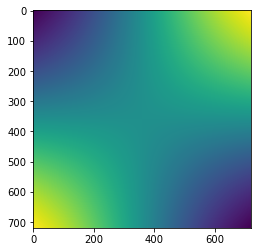

In [12]:
plt.imshow(cob[:,:,1,0])

In [17]:
p1 = cell[0, 1, :]
p2 = cell[1, 1, :]
p3 = cell[2, 1, :]
# p1 = cell[1, 0, :]
# p2 = cell[1, 1, :]
# p3 = cell[1, 2, :]

xyz1 = mf2w.sph2cart(p1, degrees=True)
xyz2 = mf2w.sph2cart(p2, degrees=True)
xyz3 = mf2w.sph2cart(p3, degrees=True)

uvect = xyz3 - xyz1
ap = np.dot(uvect,xyz2) 
print(uvect)
print(ap)
uvect = uvect - ap*xyz2
ap = np.dot(uvect,uvect)
uvect=uvect/np.sqrt(ap)

print(uvect)

[ 0.00056673 -0.00080781  0.00139678]
-1.0675222641629012e-12
[ 0.33138264 -0.47235108  0.81674354]


In [86]:
def get_cart_unit_vectors(grid):
    pl = np.concatenate((grid.lats.values[..., np.newaxis], grid.lons.values[..., np.newaxis]), -1)
    xyz = mf2w.sph2cart(pl, degrees=True)

    center = xyz[1::2, 1::2, :]
    edge_u = xyz[1::2, 2::2, :]
    edge_v = xyz[2::2, 1::2, :]
    u = edge_u - center
    mag = np.sqrt(np.expand_dims(np.einsum('ijk,ijk->ij', u, u), -1))
    u /= mag
    v = edge_v - center
    mag = np.sqrt(np.expand_dims(np.einsum('ijk,ijk->ij', v, v), -1))
    v /= mag
    return np.moveaxis([u, v], 0, -2)

def get_north_east_unit_vectors(grid):
    x = np.deg2rad(grid.lons.values[1::2, 1::2])
    y = np.deg2rad(grid.lats.values[1::2, 1::2])
    M = np.zeros((*x.shape, 2, 3))
    M[:,:, 0, 0] = -np.sin(x)
    M[:,:, 0, 1] = np.cos(x)
    M[:,:, 0, 2] = 0.0
    M[:,:, 1, 0] = -np.sin(y)*np.cos(x)
    M[:,:, 1, 1] = -np.sin(y)*np.sin(x)
    M[:,:, 1, 2] = np.cos(y)
    return M

In [87]:
uv = get_cart_unit_vectors(grid)
ne = get_north_east_unit_vectors(grid)

In [88]:
ne

array([[[[ 0.8186315 ,  0.57431914,  0.        ],
         [ 0.33138264, -0.47235108,  0.81674354]],

        [[ 0.81758743,  0.57580447,  0.        ],
         [ 0.3326406 , -0.47231792,  0.81625119]],

        [[ 0.8165394 ,  0.5772897 ,  0.        ],
         [ 0.33389959, -0.47227964,  0.81575915]],

        ...,

        [[-0.56985135,  0.8217478 ,  0.        ],
         [ 0.47529214,  0.32959731,  0.81575915]],

        [[-0.57134415,  0.82071059,  0.        ],
         [ 0.47412216,  0.33006388,  0.81625119]],

        [[-0.57283326,  0.81967192,  0.        ],
         [ 0.4729514 ,  0.33052529,  0.81674354]]],


       [[[ 0.8186315 ,  0.57431914,  0.        ],
         [ 0.33057996, -0.47120694,  0.81772912]],

        [[ 0.81758743,  0.57580447,  0.        ],
         [ 0.33183584, -0.47117524,  0.81723857]],

        [[ 0.8165394 ,  0.5772897 ,  0.        ],
         [ 0.33309275, -0.47113842,  0.81674831]],

        ...,

        [[-0.56985135,  0.8217478 ,  0.        ],
  